<a href="https://colab.research.google.com/github/slopatek/Crude_Oil_Prices_Time_Series_Analysis/blob/main/Crude_Oil_Prices_TSA_Part_02_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Crude Oil Prices - Time Series Analysis (Part 2)**

The ultimate objective is to model crude oil prices using machine learning techniues. In part 1 my focus was on SARIMA & ETS models while here I will turn to some of the deep learning modelling experiments in order to test their potential... still in a univariate setup.

# **Preparing the ground**

Let's import usual suspects, code some useful functions and eventually download the data, that we will work with....

##**Required imports**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow.keras import layers
import os
import datetime as dt
from timeit import default_timer as timer 


## **GPU check**

Let's see if we have access to some hardware accelerator.


In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cca949a5-e17e-28b4-5f81-78e2cdb21b90)


##**Useful functions**

The following functions might turn out to be useful at a later stage.

In [5]:
def scatter_ts(timesteps, values, start=0, end=None, label=None, chart_title=None, size = 10, color = "red"): #'#E50000'
  plt.scatter(timesteps[start:end], values[start:end], c = color, s = size, label=label)
  plt.xlabel("Date")
  plt.ylabel("Brent Price (USD/bbl)")
  if label:
    plt.legend(fontsize=12)
  plt.title(chart_title)
  plt.grid(True)

def calculate_mase(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  naive_mae = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / naive_mae

def assess_preds(y_true, y_pred):
  y_true = tf.squeeze(tf.cast(y_true, dtype=tf.float32))
  y_pred = tf.squeeze(tf.cast(y_pred, dtype=tf.float32))
  mse = (tf.keras.metrics.mean_squared_error(y_true, y_pred)).numpy()
  rmse = (tf.sqrt(mse)).numpy()
  mae = (tf.keras.metrics.mean_absolute_error(y_true, y_pred)).numpy()  
  mape = (tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)).numpy()
  mase = (calculate_mase(y_true, y_pred)).numpy() 
  error_dict = {"error_type":["mse", "rmse","mae", "mape", "mase"],
                "error_value":[mse, rmse, mae, mape, mase]}
  error_df = pd.DataFrame(error_dict["error_value"], index = error_dict["error_type"], columns=["error"])
  return np.round(error_df,3)

def vectorized_split_sequence(sequence, steps_in, steps_out):
  if type(sequence) != np.ndarray:
    sequence = np.array(sequence)
  window_step = np.expand_dims(np.arange(steps_in), axis = 0)
  horizon_step = np.expand_dims(np.arange(steps_in, steps_in + steps_out), axis = 0)
  window_indexes = window_step + np.expand_dims(np.arange(len(sequence)-(steps_in + steps_out - 1)), axis = 1)
  horizon_indexes = horizon_step + np.expand_dims(np.arange(len(sequence)-(steps_in + steps_out - 1)), axis = 1)
  return sequence[window_indexes], sequence[horizon_indexes]

def create_checkpoint(name, path = "models_tried"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path, name),
                                            verbose=0,
                                            save_best_only=True)
  
def assess_predictions(actual_data, predicted_data):
  actual_data = tf.squeeze(tf.cast(actual_data, dtype = tf.float32))
  predicted_data = tf.squeeze(tf.cast(predicted_data, dtype=tf.float32))
  pred_error = np.round(tf.sqrt(tf.keras.metrics.mean_squared_error(actual_data, predicted_data)),3)
  return pred_error

def train_test_splitting(data, test_percent = 0.2):
  test_size = int(len(data) * test_percent)
  return data[:-test_size], data[-test_size:]

##**Data retrieval**

Two major crude oil futures contracts are WTI (West Texas Intermediate) traded on NYMEX (New York Mercantile Exchange) and Brent traded on ICE (InterContinental Exchange) in London. Just like in part 1, we will choose to work with the latter one.

In [6]:
!wget https://raw.githubusercontent.com/slopatek/Crude_Oil_Prices_Time_Series_Analysis/main/ICE_Brent.csv
brent = pd.read_csv("ICE_Brent.csv", sep = ";", usecols = ["Date", "Close"], index_col = "Date", parse_dates = True)
brent["Close"] = brent["Close"].str.replace(',', '.').astype("float64")
print("\n","#"*100, "\n")
brent.info()

--2023-02-08 11:53:13--  https://raw.githubusercontent.com/slopatek/Crude_Oil_Prices_Time_Series_Analysis/main/ICE_Brent.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314098 (307K) [text/plain]
Saving to: ‘ICE_Brent.csv’

ICE_Brent.csv       100%[===================>] 306.74K  --.-KB/s    in 0.004s  

2023-02-08 11:53:14 (75.0 MB/s) - ‘ICE_Brent.csv’ saved [314098/314098]


 #################################################################################################### 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8833 entries, 1988-06-24 to 2023-01-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8833 non-null   float64
dtypes: float64(1)
memory usage: 138.0 KB


All right, we have some 9k of data at our disposal.

##**Price history**

Visualizing price behavior since 1988

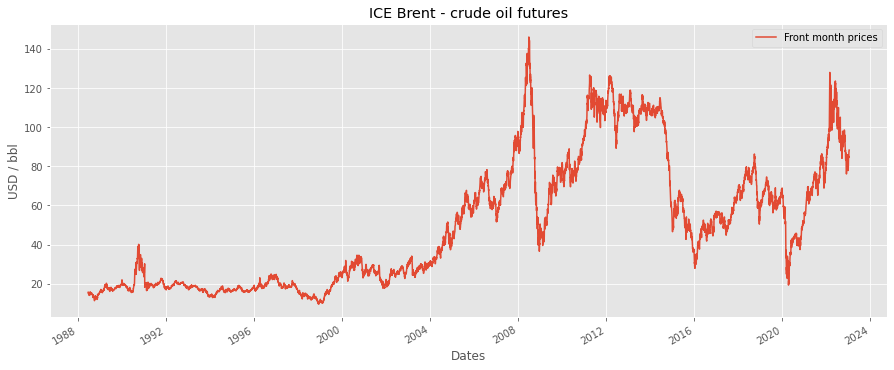

In [ ]:
# plt.style.use("ggplot")
brent.Close.plot(figsize=(15,6), label = "Front month prices")
plt.title("ICE Brent - crude oil futures")
plt.ylabel("USD / bbl")
plt.xlabel("Dates")
plt.legend();

## **Train / Test split**

If we hadn't dealt with time series, we would certainly use famous train_test_split from sklearn.model_selection but modelling of time series requires a dedicated approach. In simple terms it comes down to curving a train set up to a certain cutt-off point while the remaining data points constitute a test set.

In [7]:
start_date = dt.date(2008, 1, 1) 
end_date = dt.date(2023, 1, 1)
brent_subset = brent.loc[start_date:end_date].copy()
brent_train, brent_test = train_test_splitting(brent_subset.Close)

In [8]:
brent_train.shape, brent_test.shape

((3100,), (774,))

All right. We've got 3100 samples in our train set and 774 samples in our test set. Let's visualize the split over the most recent 15 years...

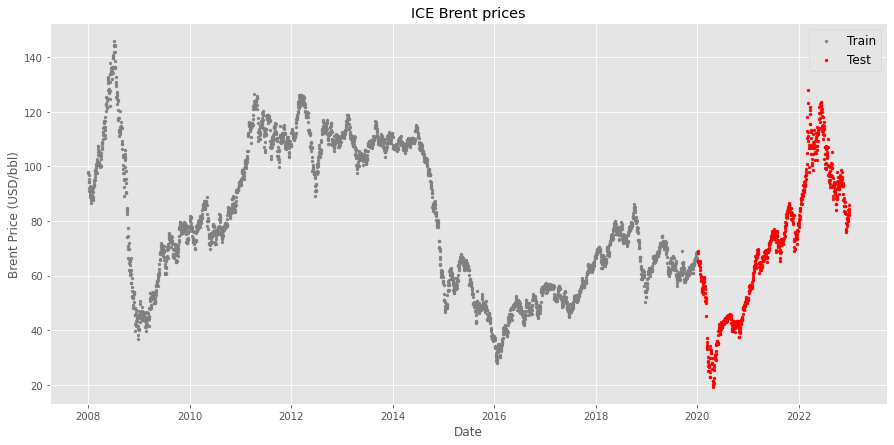

In [ ]:
plt.figure(figsize=(15, 7))
scatter_ts(timesteps=brent_train.index, values=brent_train.values, label="Train", size=8, color = "grey")
scatter_ts(timesteps=brent_test.index, values=brent_test.values, label="Test", chart_title = "ICE Brent prices", size=8, color = "red")

# **Models tried**

Now would be a good moment to try modeling Brent prices using different deep learning approaches. As a baseline we will use our faithful naive model.



| Number | Model Type | Layers | Units | |
| ----- | ----- | ----- | ----- | - |
| 1 | Naive |   NA |   NA |
| 2 | MLP | 1 / 3  |   128 / 256 |
| 3 | LSTM | 1 / 3  |   128 / 256 |
| 4 | CNN | 1 / 3  |   128 / 256 | 

## **Naive forecast** 

Let's start from setting a benchmark for the assessment of effectiveness of all other models tried. The obvious choice is usually a naive model which assumes persistence of past data into the future. We will test lags 1 through 4 by default.

In [39]:
def naive_model_configs(lags = 4):
  n_options = [i for i in range(1, lags +1)]
  return n_options
  
def naive_forecast(data, configuration):
  return data[-configuration]

def avg_naive_error(train_data, test_data, configuration, iterator):
  start_time = timer()
  naive_archive = train_data.copy()
  naive_predictions = list()
  for i in range(len(test_data)):
    y_hat = naive_forecast(naive_archive, configuration)
    naive_predictions.append(y_hat)
    naive_archive = pd.concat([naive_archive, test_data[i:i+1]])
  try:
    naive_error = assess_predictions(test_data, naive_predictions).round(3)
  except:
    naive_error = None
  end_time = timer() #dt.datetime.now()
  print(f"Model: {iterator+1} \t Error: {naive_error:.3f} \t \t Configuration: {configuration} \t \t Time: {round((end_time - start_time)/60,2)}")
  return (np.round(naive_error,3), configuration)

def naive_grid_search(train_set, test_set, naive_conf_options):
  start_point = timer()
  naive_results = [avg_naive_error(train_data = train_set, test_data = test_set, configuration = config, iterator=index) for index, config in enumerate(naive_conf_options)]
  naive_results = [r for r in naive_results if r[0] != None]
  naive_results.sort(key=lambda tup: tup[0])
  end_point = timer()
  #print(f"\n Total of {len(naive_conf_options)} models calculated in {round((end_point - start_point)/60,2)} minutes.")
  naive_df = pd.DataFrame(data = naive_results,
                          columns =['error', 'config'])
  return naive_df

In [17]:
naive_confs = naive_model_configs(lags = 4)
naive_gs = naive_grid_search(train_set = brent_train,
                             test_set = brent_test,
                             naive_conf_options = naive_confs)
naive_gs

Model: 1 	 Error: 2.129 	 	 Configuration: 1 	 	 Time: 0.0
Model: 2 	 Error: 3.056 	 	 Configuration: 2 	 	 Time: 0.0
Model: 3 	 Error: 3.691 	 	 Configuration: 3 	 	 Time: 0.0
Model: 4 	 Error: 4.184 	 	 Configuration: 4 	 	 Time: 0.0


,error,config
0,2.129,1
1,3.056,2
2,3.691,3
3,4.184,4


Without surprises, best results yielded a naive model with a lag of 1.

## **MLP**

MLP stands for Multi Layer Perceptron aka a dense model. True, it is not natively skilled to work with sequences but we will still give it a go.

In [1]:
def mlp_model_configs():
  n_layers_options = [1, 3]
  n_units_options = [128, 256]
  n_steps_in_options = [5]
  n_batch_size_options = [1]
  n_dropout_options = [0.10]
  cfg_list = list()
  for i in n_layers_options:
    for j in n_units_options:
      for k in n_steps_in_options:
        for l in n_batch_size_options:
          for m in n_dropout_options:
            configuration = [i, j, k, l, m]
            cfg_list.append(configuration)
  return cfg_list

def get_mlp(configuration, train_data, test_data):
  n_epochs, n_outputs = 80, 1
  n_layers, n_units, n_inputs, n_batch_size, n_dropout_ratio = configuration
  checkpoint_path = "mlp_checkpoints_weights/checkpoint.ckpt"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         save_freq = "epoch",
                                                         verbose=0)  
  X_train, y_train = vectorized_split_sequence(sequence = train_data, steps_in = n_inputs, steps_out = n_outputs)
  X_test, y_test = vectorized_split_sequence(sequence = test_data, steps_in = n_inputs, steps_out = n_outputs)
  X_train_tf = tf.cast(X_train, dtype = tf.float32)
  y_train_tf = tf.cast(y_train, dtype = tf.float32)
  X_val_tf = tf.cast(X_test, dtype = tf.float32)
  y_val_tf = tf.cast(y_test, dtype = tf.float32)
  model = tf.keras.Sequential(name = f"mlp_{n_layers}_{n_units}_{n_inputs}_{n_batch_size}_{int(n_dropout_ratio*100)}")
  if n_layers==1:
    model.add(tf.keras.layers.Dense(n_units, activation='relu', input_dim = n_inputs))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  else:
    model.add(tf.keras.layers.Dense(n_units, activation='relu', input_dim = n_inputs)) #
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    for i in range(1, n_layers):
      model.add(tf.keras.layers.Dense(n_units, activation='relu')) #, input_dim = inputs
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  model.add(tf.keras.layers.Dense(n_outputs))
  model.compile(loss = 'mse',
                optimizer='adam')
 
  model.fit(x = X_train_tf,
            y = y_train_tf,
            batch_size = n_batch_size, 
            epochs = n_epochs,
            verbose=0,
            validation_data=(X_val_tf, y_val_tf),
            callbacks = [checkpoint_callback])
  model.load_weights(filepath = checkpoint_path)

  model_path = f"saved_models/{model.name}" 
  model.save(model_path) 

  predictions = model.predict(X_val_tf) #tf.constant
  error = assess_predictions(y_val_tf, predictions).round(3)

  return error, configuration, model.name, model_path

def mlp_grid_search(configuration_list, train_set, test_set):
  mlp_results = list()
  for conf in configuration_list:
    result = get_mlp(configuration = conf,
                     train_data = train_set,
                     test_data = test_set)
    mlp_results.append(result)
    mlp_results.sort(key=lambda tup:tup[0])
    mlp_df = pd.DataFrame(data = mlp_results,
                          columns =['error', 'config', 'model_name', 'model_path'])
  return mlp_df

In [9]:
mlp_configs = mlp_model_configs()
mlp_gs = mlp_grid_search(configuration_list = mlp_configs,
                         train_set = brent_train,
                         test_set = brent_test)
mlp_gs

25/25 [==============================] - 0s 3ms/step


,error,config,model_name,model_path
0,2.150,"[1, 256, 5, 1, 0.1]",mlp_1_256_5_1_10,saved_models/mlp_1_256_5_1_10
1,2.163,"[1, 128, 5, 1, 0.1]",mlp_1_128_5_1_10,saved_models/mlp_1_128_5_1_10
2,2.358,"[3, 256, 5, 1, 0.1]",mlp_3_256_5_1_10,saved_models/mlp_3_256_5_1_10
3,2.815,"[3, 128, 5, 1, 0.1]",mlp_3_128_5_1_10,saved_models/mlp_3_128_5_1_10


It does not bit naive model so let's try some recurrent neural net...

## **LSTM**

LSTM stands for Long-Short Term Memory cells that were specifically designed to work with  sequences. Let's find out if they show higher skills than a regular dense model... 

In [9]:
def lstm_model_configs():
  n_layers_options = [1,3]
  n_units_options = [128, 256]
  n_steps_in_options = [5]
  n_batch_size_options = [1]
  n_dropout_options = [0.10]
  cfg_list = list()
  for i in n_layers_options:
    for j in n_units_options:
      for k in n_steps_in_options:
        for l in n_batch_size_options:
          for m in n_dropout_options:
            configuration = [i, j, k, l, m]
            cfg_list.append(configuration)
  return cfg_list

def get_lstm(configuration, train_data, test_data):
  n_epochs, n_outputs = 80, 1
  n_layers, n_units, n_inputs, n_batch_size, n_dropout_ratio = configuration
  checkpoint_path = "lstm_checkpoints_weights/checkpoint.ckpt"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         save_freq = "epoch",
                                                         verbose=0)  
  X_train, y_train = vectorized_split_sequence(sequence = train_data, steps_in = n_inputs, steps_out = n_outputs)
  X_test, y_test = vectorized_split_sequence(sequence = test_data, steps_in = n_inputs, steps_out = n_outputs)
  X_train_tf = tf.expand_dims(X_train, axis = 2)
  y_train_tf = tf.cast(y_train, dtype = tf.float32)
  X_val_tf = tf.expand_dims(X_test, axis = 2)
  y_val_tf = tf.cast(y_test, dtype = tf.float32)
  model = tf.keras.Sequential(name = f"lstm_{n_layers}_{n_units}_{n_inputs}_{n_batch_size}_{int(n_dropout_ratio*100)}")
  if n_layers==1:
    model.add(tf.keras.layers.LSTM(n_units, activation='relu', input_shape = (n_inputs,1)))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  elif n_layers == 2:
      model.add(tf.keras.layers.LSTM(n_units, activation='relu', return_sequences = True, input_shape = (n_inputs, 1)))
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
      model.add(tf.keras.layers.LSTM(n_units, activation='relu'))
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  else:
    model.add(tf.keras.layers.LSTM(n_units, activation='relu', return_sequences = True, input_shape = (n_inputs, 1))) #
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    for i in range(2, n_layers):
      model.add(tf.keras.layers.LSTM(n_units, activation='relu', return_sequences = True))
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.LSTM(n_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  model.add(tf.keras.layers.Dense(n_outputs))
  model.compile(loss = 'mse',
                optimizer='adam')
 
  model.fit(x = X_train_tf,
            y = y_train_tf,
            batch_size = n_batch_size, 
            epochs = n_epochs,
            verbose=0,
            validation_data=(X_val_tf, y_val_tf),
            callbacks = [checkpoint_callback])
  model.load_weights(filepath = checkpoint_path)

  model_path = f"saved_models/{model.name}" 
  model.save(model_path) #/content/drive/MyDrive/models
  
  predictions = model.predict(X_val_tf) #tf.constant
  error = assess_predictions(y_val_tf, predictions).round(3)

  return error, configuration, model.name, model_path

def lstm_grid_search(configuration_list, train_set, test_set):
  lstm_results = list()
  for conf in configuration_list:
    result = get_lstm(configuration = conf,
                     train_data = train_set,
                     test_data = test_set)
    lstm_results.append(result)
    lstm_results.sort(key=lambda tup:tup[0])
    lstm_df = pd.DataFrame(data = lstm_results,
                          columns =['error', 'config', 'model_name', 'model_path'])
  return lstm_df

In [10]:
lstm_configs = lstm_model_configs()
lstm_gs = lstm_grid_search(configuration_list = lstm_configs,
                         train_set = brent_train,
                         test_set = brent_test)
lstm_gs

25/25 [==============================] - 0s 4ms/step


25/25 [==============================] - 0s 3ms/step


25/25 [==============================] - 1s 6ms/step


25/25 [==============================] - 1s 5ms/step


,error,config,model_name,model_path
0,2.237,"[1, 256, 5, 1, 0.1]",lstm_1_256_5_1_10,saved_models/lstm_1_256_5_1_10
1,2.302,"[1, 128, 5, 1, 0.1]",lstm_1_128_5_1_10,saved_models/lstm_1_128_5_1_10
2,2.458,"[3, 128, 5, 1, 0.1]",lstm_3_128_5_1_10,saved_models/lstm_3_128_5_1_10
3,2.720,"[3, 256, 5, 1, 0.1]",lstm_3_256_5_1_10,saved_models/lstm_3_256_5_1_10


## **CNN**

CNN stands for Convolutional Neural Network. This very class of artificial neural nets was specifically designed to work with vision (images & video) but it may be used for time series analyses too.

In [7]:
def cnn_model_configs():
  n_layers_options = [1, 3]
  n_units_options = [128, 256]
  n_steps_in_options = [5]
  n_batch_size_options = [1]
  n_dropout_options = [0.10]
  cfg_list = list()
  for i in n_layers_options:
    for j in n_units_options:
      for k in n_steps_in_options:
        for l in n_batch_size_options:
          for m in n_dropout_options:
            configuration = [i, j, k, l, m]
            cfg_list.append(configuration)
  return cfg_list

def get_cnn(configuration, train_data, test_data):
  n_epochs, n_outputs = 80, 1
  n_layers, n_units, n_inputs, n_batch_size, n_dropout_ratio = configuration
  checkpoint_path = "cnn_checkpoints_weights/checkpoint.ckpt"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         save_freq = "epoch",
                                                         verbose=0)  
  X_train, y_train = vectorized_split_sequence(sequence = train_data, steps_in = n_inputs, steps_out = n_outputs)
  X_test, y_test = vectorized_split_sequence(sequence = test_data, steps_in = n_inputs, steps_out = n_outputs)
  X_train_tf = tf.cast(X_train, dtype = tf.float32)
  y_train_tf = tf.cast(y_train, dtype = tf.float32)
  X_test_tf = tf.cast(X_test, dtype = tf.float32)
  y_test_tf = tf.cast(y_test, dtype = tf.float32)
  model = tf.keras.Sequential(name = f"cnn_{n_layers}_{n_units}_{n_inputs}_{n_batch_size}_{int(n_dropout_ratio*100)}")
  model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)))
  if n_layers==1:
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu', input_shape = (n_inputs, 1)))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Flatten())
    
  elif n_layers == 2:
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu', input_shape = (n_inputs, 1)))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu'))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Flatten())

  else:
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu', input_shape = (n_inputs, 1)))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    for i in range(2, n_layers):
      model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu'))
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu'))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(n_outputs))

  model.compile(loss = 'mse',
                optimizer='adam')
 
  model.fit(x = X_train_tf,
            y = y_train_tf,
            batch_size = n_batch_size, 
            epochs = n_epochs,
            verbose=0, #0
            validation_data=(X_test_tf, y_test_tf),
            callbacks = [checkpoint_callback])
  model.load_weights(filepath = checkpoint_path)

  model_path = f"saved_models/{model.name}" 
  model.save(model_path)
  predictions = tf.squeeze(model.predict(X_test), axis=-1)
  error = assess_predictions(y_test_tf, predictions).round(3)
  
  return error, configuration, model.name, model_path

def cnn_grid_search(configuration_list, train_set, test_set):
  cnn_results = list()
  for conf in configuration_list:
    result = get_cnn(configuration = conf,
                     train_data = train_set,
                     test_data = test_set)
    cnn_results.append(result)
    cnn_results.sort(key=lambda tup:tup[0])
    cnn_df = pd.DataFrame(data = cnn_results,
                          columns =['error', 'config', 'model_name', 'model_path'])
  return cnn_df

In [8]:
cnn_configs = cnn_model_configs()
cnn_gs = cnn_grid_search(configuration_list = cnn_configs,
                         train_set = brent_train,
                         test_set = brent_test)
cnn_gs

25/25 [==============================] - 0s 2ms/step


25/25 [==============================] - 0s 2ms/step


25/25 [==============================] - 0s 3ms/step


25/25 [==============================] - 0s 2ms/step


,error,config,model_name,model_path
0,4.082,"[1, 256, 5, 1, 0.1]",cnn_1_256_5_1_10,saved_models/cnn_1_256_5_1_10
1,4.196,"[3, 256, 5, 1, 0.1]",cnn_3_256_5_1_10,saved_models/cnn_3_256_5_1_10
2,4.239,"[3, 128, 5, 1, 0.1]",cnn_3_128_5_1_10,saved_models/cnn_3_128_5_1_10
3,5.145,"[1, 128, 5, 1, 0.1]",cnn_1_128_5_1_10,saved_models/cnn_1_128_5_1_10


# **Executive Summary**

Time to collect results of the best 4 models of each class in a summary data frame.

In [35]:
results_df = pd.DataFrame({'naive': naive_gs.error,
                           'mlp': mlp_gs.error,
                           'lstm':lstm_gs.error,
                           'cnn': cnn_gs.error})
results_df.index = pd.RangeIndex(start=1, stop=5, step=1)
results_df.index = results_df.index.set_names(['rank'])
results_df

,naive,mlp,lstm,cnn
rank,,,,
1,2.129,2.150,2.237,4.082
2,3.056,2.163,2.302,4.196
3,3.691,2.358,2.458,4.239
4,4.184,2.815,2.720,5.145


It would not be a bad idea to visualize the results.

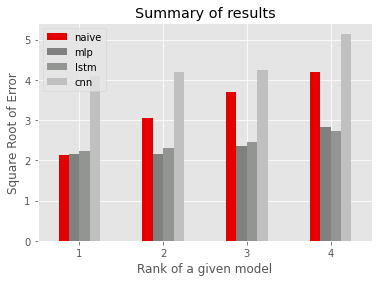

In [38]:
results_df.plot.bar(color=['#E50000','#808080','#929591',   '#C0C0C0'])
plt.title("Summary of results")
plt.xlabel("Rank of a given model")
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel("Square Root of Error");

**Key takeaways:**



Deep Learning techniques have hard time bitting very simple naive model

We could try fine-tuning playing with different hyperparameters like: learing rate, activation functions, initializations methods, number of layers, number of units and so on...

Instead, in the next part we will attempt to verify whether adding exogenous variables has potential to add value to our modelling experiments of Brent prices...